In [1]:
import os
import copy
import sys
import time
import math
from datetime import datetime
import time

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from functools import reduce
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import ParameterGrid
import joblib

import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

from luca_utils import *

### check for GPU's
use_gpu = torch.cuda.is_available()

In [2]:
### Get data dict for ess and dss 
eval_type = 'val'
ess_dir = '../'
ess_model_results = 'ess_b32_h128_lr1e4_g99_1/'
dss_dir = '../../dss/'
dss_model_results = 'dss_b33_h128_lr1e4_g99_1/'

ess_data_dict = joblib.load(os.path.join(ess_dir, 'data/ess_data_dict.pkl'))
ess_Q_values =  pd.read_csv(os.path.join(ess_dir, 'models/', ess_model_results, 'DQN_Qvalues_' + eval_type + 'data.csv'))
ess_pi_values =  pd.read_csv(os.path.join(ess_dir, 'models/', ess_model_results, 'DQN_action_prob_df_' + eval_type + 'data.csv'))

In [3]:
dss_data_dict = joblib.load(os.path.join(dss_dir, 'data/dss_data_dict.pkl'))
dss_Q_values =  pd.read_csv(os.path.join(dss_dir, 'models/', dss_model_results, 'DQN_Qvalues_' + eval_type + 'data.csv'))
dss_pi_values =  pd.read_csv(os.path.join(dss_dir, 'models/', dss_model_results, 'DQN_action_prob_df_' + eval_type + 'data.csv'))

In [6]:
batch_ids           = dss_data_dict[eval_type]['state_id']
actions_sequence    = dss_pi_values['best_action'][batch_ids] # actual actions from data dictionary
rewards_sequence    = dss_data_dict[eval_type]['reward'][(batch_ids)] # actual rewards from data dictionary
fence_posts         = get_fence_post(ess_data_dict, eval_type) # list of indexes from data_dictionary to mark the beginning of a trajectory by it' index (state ID)

#DSS datas
DSS_pi = dss_pi_values.iloc[:, :21]
DSS_action = dss_pi_values['best_action'][batch_ids]
DSS_Q = dss_Q_values.iloc[:,:21]
DSS_V = DSS_Q.max(axis=1)

#ESS datas
ESS_pi = ess_pi_values.iloc[:, :21]
ESS_action = ess_pi_values['best_action'][batch_ids]
ESS_Q = ess_Q_values.iloc[:,:21]
ESS_V = ESS_Q.max(axis=1)

In [92]:
### Compare DSS with ESS by considering DSS is base line and behavioural policy 
dss_WDR, dss_wis = WDR(DSS_action, rewards_sequence, fence_posts, 0.99, DSS_pi, DSS_pi, V=DSS_V, Q= DSS_Q)
ess_WDR, ess_wis = WDR(actions_sequence, rewards_sequence, fence_posts, 0.99, ESS_pi, DSS_pi,  V=DSS_V, Q= DSS_Q)

print('DSS_WDR', dss_WDR, 'DSS_WIS ', dss_wis)
print('ess_WDR', ess_WDR, 'ess_WIS ', ess_wis)


DSS_WDR 9.294135889009064 DSS_WIS  9.294135889009064
ess_WDR 5.635600999343436 ess_WIS  2.7924820007547644


In [94]:
### Compare DSS with ESS by considering ESS is base line and behavioural policy 
ess_WDR, ess_wis = WDR(ESS_action, rewards_sequence, fence_posts, 0.99, ESS_pi, ESS_pi, V=ESS_V, Q= ESS_Q)
dss_WDR, dss_wis = WDR(ESS_action, rewards_sequence, fence_posts, 0.99, DSS_pi, ESS_pi,  V=ESS_V, Q= ESS_Q)

print('behviour ', 'ess_WDR', ess_WDR, 'ess_WIS ', ess_wis)
print('target ', 'DSS_WDR', dss_WDR, 'DSS_WIS ', dss_wis)

behviour  ess_WDR 9.294135889009064 ess_WIS  9.294135889009064
target  DSS_WDR 14.31911053990693 DSS_WIS  12.59613056942735


##### compare action space based on mcnemar test 

In [5]:
from mlxtend.evaluate import mcnemar, mcnemar_table

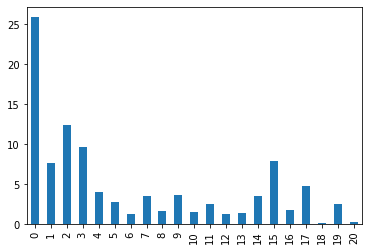

In [14]:
import seaborn as sns
(ESS_action.value_counts()/ESS_action.shape[0] *100).sort_index().plot(kind='bar')

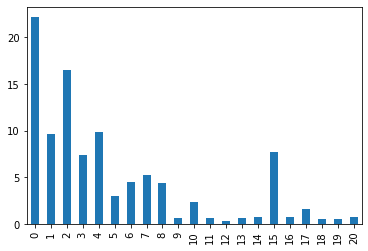

In [15]:
(DSS_action.value_counts()/DSS_action.shape[0] *100).sort_index().plot(kind='bar')

In [17]:
phy_val_action = ess_data_dict['val']['action']

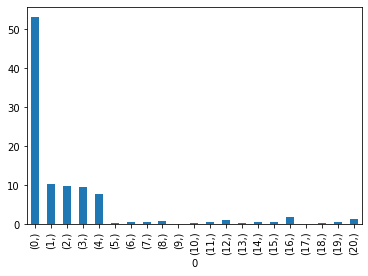

In [19]:
(pd.DataFrame(phy_val_action).value_counts()/phy_val_action.shape[0] *100).sort_index().plot(kind='bar')

In [20]:
tb = mcnemar_table(y_target=phy_val_action, 
                   y_model1=DSS_action, 
                   y_model2=ESS_action)

In [21]:
chi2, p = mcnemar(ary=tb, corrected=True)
print('chi-squared:', chi2)
print('p-value:', p)

chi-squared: 718.6292244897959
p-value: 2.659083711611317e-158
